In [10]:
import warnings
# Ignorer les avertissements futurs et les avertissements d'utilisateur spécifiques
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import pandas as pd
import numpy as np

# Load the datasets
general_data = pd.read_csv('csv_in/general_data.csv')
employee_survey = pd.read_csv('csv_in/employee_survey_data.csv')
manager_survey = pd.read_csv('csv_in/manager_survey_data.csv')
in_time = pd.read_csv('csv_in/in_time.csv')
out_time = pd.read_csv('csv_in/out_time.csv')

# Inspect General Data
print("--- General Data Info ---")
print(general_data.info())
print("\n--- General Data Head ---")
print(general_data.head())

# Inspect Employee Survey
print("\n--- Employee Survey Info ---")
print(employee_survey.info())
print("\n--- Employee Survey Head ---")
print(employee_survey.head())

# Inspect Manager Survey
print("\n--- Manager Survey Info ---")
print(manager_survey.info())
print("\n--- Manager Survey Head ---")
print(manager_survey.head())

# Inspect In Time
print("\n--- In Time Info ---")
print(in_time.info())
print("\n--- In Time Head ---")
print(in_time.iloc[:, :5].head()) # Show first 5 cols

# Inspect Out Time
print("\n--- Out Time Info ---")
print(out_time.info())
print("\n--- Out Time Head ---")
print(out_time.iloc[:, :5].head())

--- General Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14

In [11]:
# 1. Imputation

# General Data (Numerical)
for col in ['NumCompaniesWorked', 'TotalWorkingYears']:
    general_data[col] = general_data[col].fillna(general_data[col].median())

# Employee Survey (Categorical/Ordinal)
for col in ['EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance']:
    employee_survey[col] = employee_survey[col].fillna(employee_survey[col].mode()[0])

# 2. Merging HR Data
# Merge general_data + manager_survey + employee_survey
main_df = general_data.merge(manager_survey, on='EmployeeID', how='inner')
main_df = main_df.merge(employee_survey, on='EmployeeID', how='inner')

# 3. Processing Time Data
# Rename ID column
in_time.rename(columns={'Unnamed: 0': 'EmployeeID'}, inplace=True)
out_time.rename(columns={'Unnamed: 0': 'EmployeeID'}, inplace=True)

# Set index to EmployeeID to facilitate element-wise subtraction
in_time_indexed = in_time.set_index('EmployeeID')
out_time_indexed = out_time.set_index('EmployeeID')

# Convert to datetime (apply to all columns)
# Since reading csv might have parsed as object, ensure they are datetime
# This can be slow, so applying pd.to_datetime on the whole dataframe
in_time_indexed = in_time_indexed.apply(pd.to_datetime)
out_time_indexed = out_time_indexed.apply(pd.to_datetime)

# Calculate duration for each day
working_duration = out_time_indexed - in_time_indexed

# Calculate mean working duration per employee (row-wise mean)
# result is a Timedelta, we convert to hours (float)
main_df['AverageWorkingHours'] = working_duration.mean(axis=1).dt.total_seconds() / 3600

# Reset index for working_duration to merge if needed, but we assigned directly using the aligned index (assuming main_df is sorted by EmployeeID, which it is 1 to 4410)
# To be safe, let's do a merge
avg_hours = pd.DataFrame(working_duration.mean(axis=1).dt.total_seconds() / 3600, columns=['AverageWorkingHours'])
main_df = main_df.merge(avg_hours, on='EmployeeID', how='left')

# Drop the duplicate column if my previous direct assignment worked (it didn't because indices might not match perfectly without set_index)
# Actually, the merge is safer. Let's check columns.
if 'AverageWorkingHours_x' in main_df.columns:
    main_df.rename(columns={'AverageWorkingHours_x': 'AverageWorkingHours'}, inplace=True)
    main_df.drop(columns=['AverageWorkingHours_y'], inplace=True)

# 4. Final Clean Check
print("Final Data Shape:", main_df.shape)
print("Missing Values:", main_df.isnull().sum().sum())
print(main_df.head())

Final Data Shape: (4410, 30)
Missing Values: 1
   Age Attrition     BusinessTravel              Department  DistanceFromHome  \
0   51        No      Travel_Rarely                   Sales                 6   
1   31       Yes  Travel_Frequently  Research & Development                10   
2   32        No  Travel_Frequently  Research & Development                17   
3   38        No         Non-Travel  Research & Development                 2   
4   32        No      Travel_Rarely  Research & Development                10   

   Education EducationField  EmployeeCount  EmployeeID  Gender  ...  \
0          2  Life Sciences              1           1  Female  ...   
1          1  Life Sciences              1           2  Female  ...   
2          4          Other              1           3    Male  ...   
3          5  Life Sciences              1           4    Male  ...   
4          1        Medical              1           5    Male  ...   

   TrainingTimesLastYear YearsAtCompany

In [12]:
# Check column alignment
in_cols = in_time_indexed.columns
out_cols = out_time_indexed.columns

print("In-Time columns:", len(in_cols))
print("Out-Time columns:", len(out_cols))

# Check equality
are_equal = in_cols.equals(out_cols)
print("Columns are identical:", are_equal)

if not are_equal:
    print("Example Mismatch:")
    # Find mismatch
    diff_in = in_cols.difference(out_cols)
    diff_out = out_cols.difference(in_cols)
    print("In only:", diff_in[:5])
    print("Out only:", diff_out[:5])
    
# Calculate working duration again explicitly ensuring alignment if needed
# If they are just same dates but diff order, direct subtraction implies alignment by label.
# If names are different, we have a problem.

# Let's try to calculate for Employee 1 explicitly to see why it was NaN
emp1_in = in_time_indexed.loc[1]
emp1_out = out_time_indexed.loc[1]
print("Emp 1 Mean Diff:", (emp1_out - emp1_in).mean())

In-Time columns: 261
Out-Time columns: 261
Columns are identical: True
Emp 1 Mean Diff: 0 days 07:22:25.142241379


Plots saved in 'img' folder.


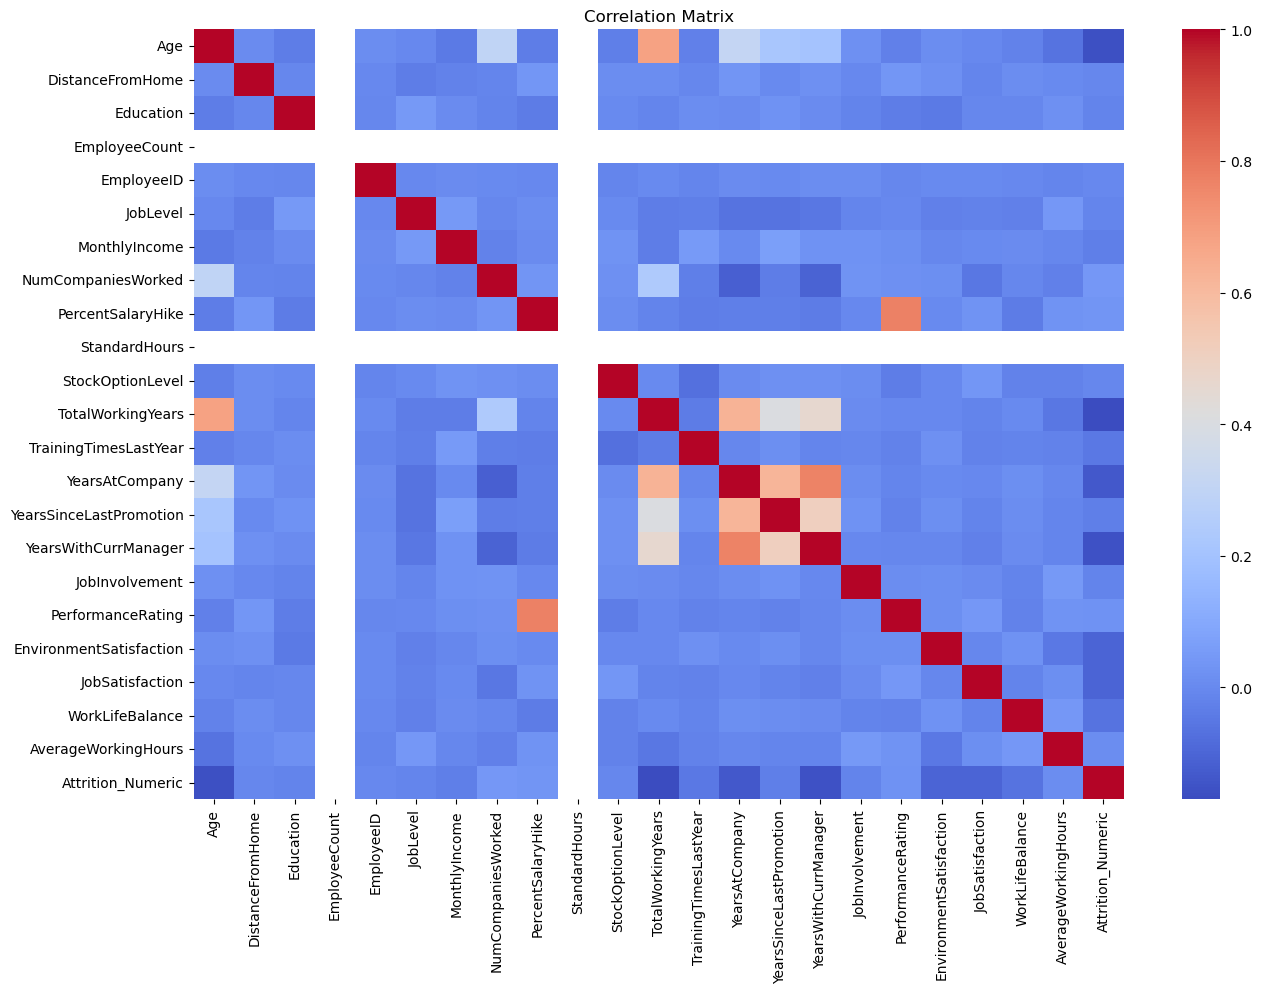

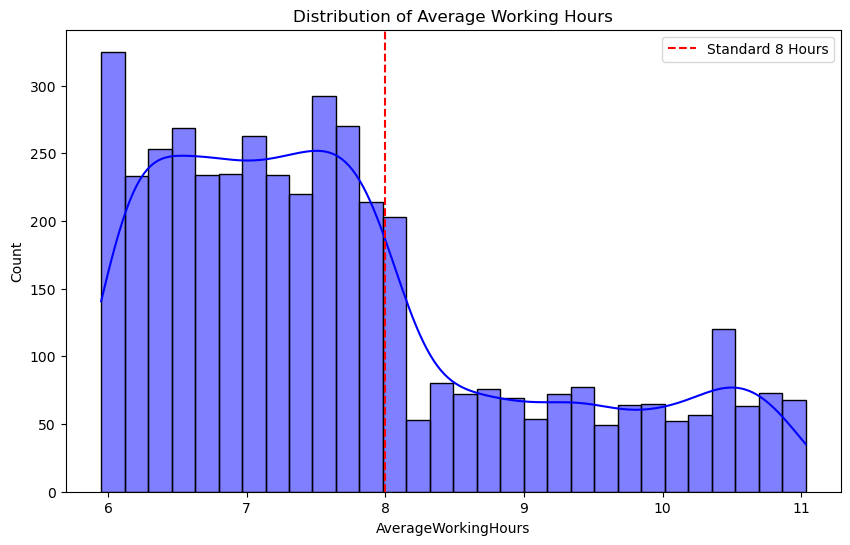

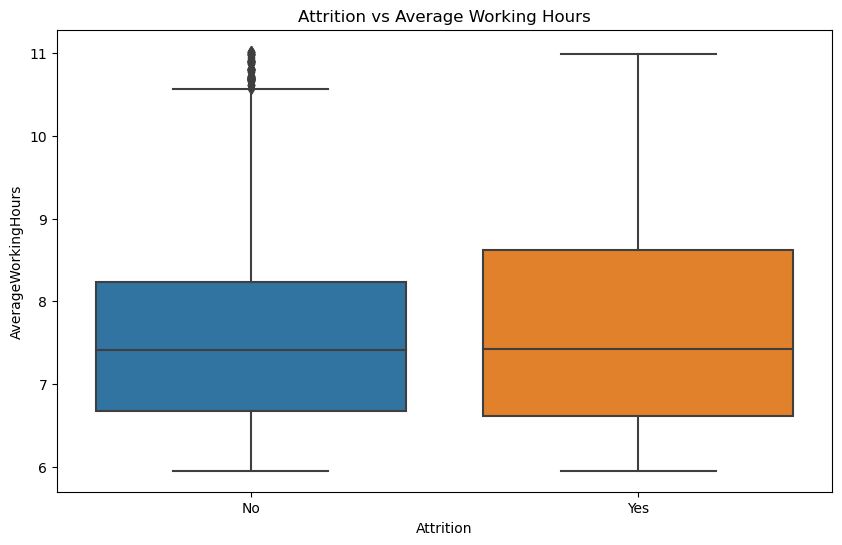

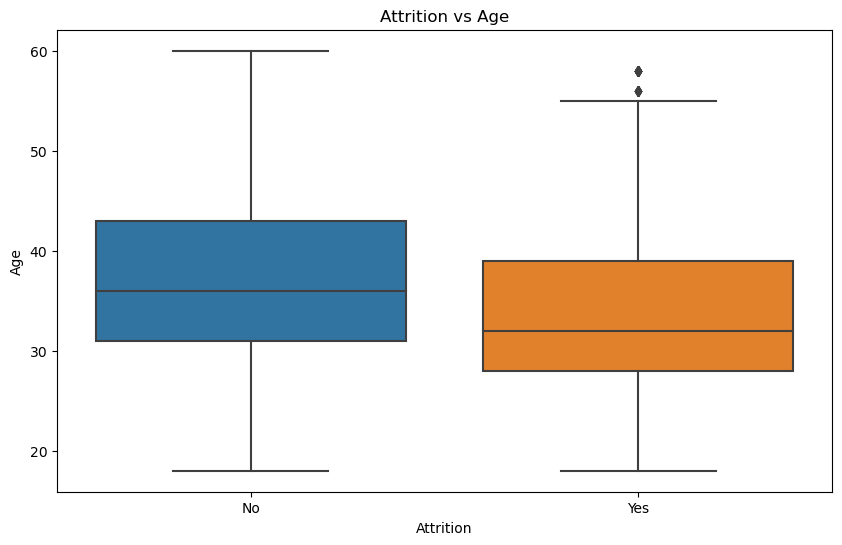

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Create img directory if it doesn't exist
if not os.path.exists('img'):
    os.makedirs('img')

# Encode Attrition for correlation analysis
main_df['Attrition_Numeric'] = main_df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

# Select numerical columns for correlation
numeric_cols = main_df.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = main_df[numeric_cols].corr()

# Plot Correlation Heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.savefig('img/correlation_heatmap.png')

# Plot Distribution of Average Working Hours
plt.figure(figsize=(10, 6))
sns.histplot(main_df['AverageWorkingHours'], kde=True, bins=30, color='blue')
plt.axvline(x=8, color='red', linestyle='--', label='Standard 8 Hours')
plt.title('Distribution of Average Working Hours')
plt.legend()
plt.savefig('img/working_hours_dist.png') 

# Plot Attrition vs Working Hours
plt.figure(figsize=(10, 6))
sns.boxplot(x='Attrition', y='AverageWorkingHours', data=main_df)
plt.title('Attrition vs Average Working Hours')
plt.savefig('img/attrition_vs_hours.png') 

# Plot Attrition vs Age
plt.figure(figsize=(10, 6))
sns.boxplot(x='Attrition', y='Age', data=main_df)
plt.title('Attrition vs Age')
plt.savefig('img/attrition_vs_age.png')

print("Plots saved in 'img' folder.")

In [14]:
print("Correlation between Attrition and Working Hours:", main_df['Attrition_Numeric'].corr(main_df['AverageWorkingHours']))
print("Correlation between Attrition and Age:", main_df['Attrition_Numeric'].corr(main_df['Age']))
print("Correlation between Attrition and TotalWorkingYears:", main_df['Attrition_Numeric'].corr(main_df['TotalWorkingYears']))

Correlation between Attrition and Working Hours: 0.011482575694022805
Correlation between Attrition and Age: -0.15920500686577962
Correlation between Attrition and TotalWorkingYears: -0.17016240718829087


In [15]:
print("Mean Working Hours:", main_df['AverageWorkingHours'].mean())
print("Max Working Hours:", main_df['AverageWorkingHours'].max())
print("Min Working Hours:", main_df['AverageWorkingHours'].min())

Mean Working Hours: 7.700953237013053
Max Working Hours: 11.030960351376944
Min Working Hours: 5.950504160548056


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create output directory if it doesn't exist
if not os.path.exists('csv_out'):
    os.makedirs('csv_out')

# 1. Loading data
# (Ensure the 'csv_in/' folder exists and contains the files)
general_data = pd.read_csv('csv_in/general_data.csv')
employee_survey = pd.read_csv('csv_in/employee_survey_data.csv')
manager_survey = pd.read_csv('csv_in/manager_survey_data.csv')
in_time = pd.read_csv('csv_in/in_time.csv')
out_time = pd.read_csv('csv_in/out_time.csv')

# 2. Handling Missing Values (Imputation)
# Numerical -> Median
for col in ['NumCompaniesWorked', 'TotalWorkingYears']:
    general_data[col] = general_data[col].fillna(general_data[col].median())

# Categorical -> Mode
for col in ['EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance']:
    employee_survey[col] = employee_survey[col].fillna(employee_survey[col].mode()[0])

# 3. Temporal Feature Engineering (Calculating working hours)
# Renaming for merging
in_time.rename(columns={'Unnamed: 0': 'EmployeeID'}, inplace=True)
out_time.rename(columns={'Unnamed: 0': 'EmployeeID'}, inplace=True)

# Converting to Datetime and Indexing
in_time_idx = in_time.set_index('EmployeeID').apply(pd.to_datetime)
out_time_idx = out_time.set_index('EmployeeID').apply(pd.to_datetime)

# Calculating duration (Out - In)
working_duration = out_time_idx - in_time_idx

# Average per employee (in hours)
avg_hours = working_duration.mean(axis=1).dt.total_seconds() / 3600
avg_hours_df = pd.DataFrame(avg_hours, columns=['AverageWorkingHours']).reset_index()

# 4. Final Merge
main_df = general_data.merge(manager_survey, on='EmployeeID', how='inner')
main_df = main_df.merge(employee_survey, on='EmployeeID', how='inner')
main_df = main_df.merge(avg_hours_df, on='EmployeeID', how='inner')

# Handling rare cases without time stamps (e.g., Employee 1 if NaN) -> Imputation with global mean
if main_df['AverageWorkingHours'].isnull().sum() > 0:
    main_df['AverageWorkingHours'].fillna(main_df['AverageWorkingHours'].mean(), inplace=True)

# Binary encoding of the target for analysis
main_df['Attrition_Numeric'] = main_df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

# Save to csv_out directory
output_path = os.path.join('csv_out', 'final_dataset.csv')
main_df.to_csv(output_path, index=False)
print(f"Dataset successfully generated: {output_path}")
print(f"Dimensions: {main_df.shape}")

Dataset successfully generated: csv_out\final_dataset.csv
Dimensions: (4410, 31)


Dimensions après encodage : (4410, 39)

--- 1. Régression Logistique ---
Accuracy: 0.8540344514959202

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.97      0.92       925
           1       0.62      0.25      0.35       178

    accuracy                           0.85      1103
   macro avg       0.74      0.61      0.64      1103
weighted avg       0.83      0.85      0.83      1103


--- 2. Random Forest ---
Accuracy: 0.9882139619220308

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       925
           1       1.00      0.93      0.96       178

    accuracy                           0.99      1103
   macro avg       0.99      0.96      0.98      1103
weighted avg       0.99      0.99      0.99      1103



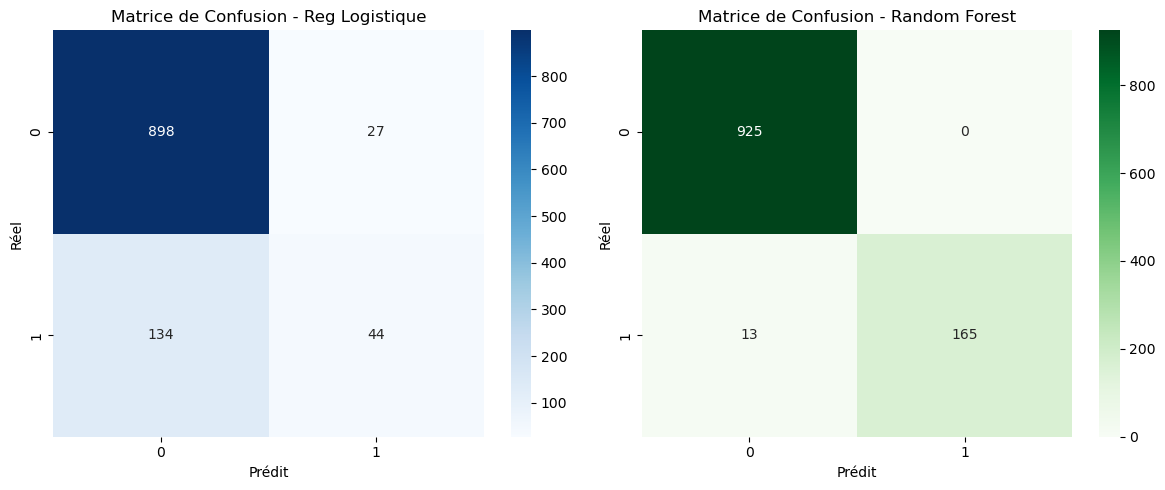

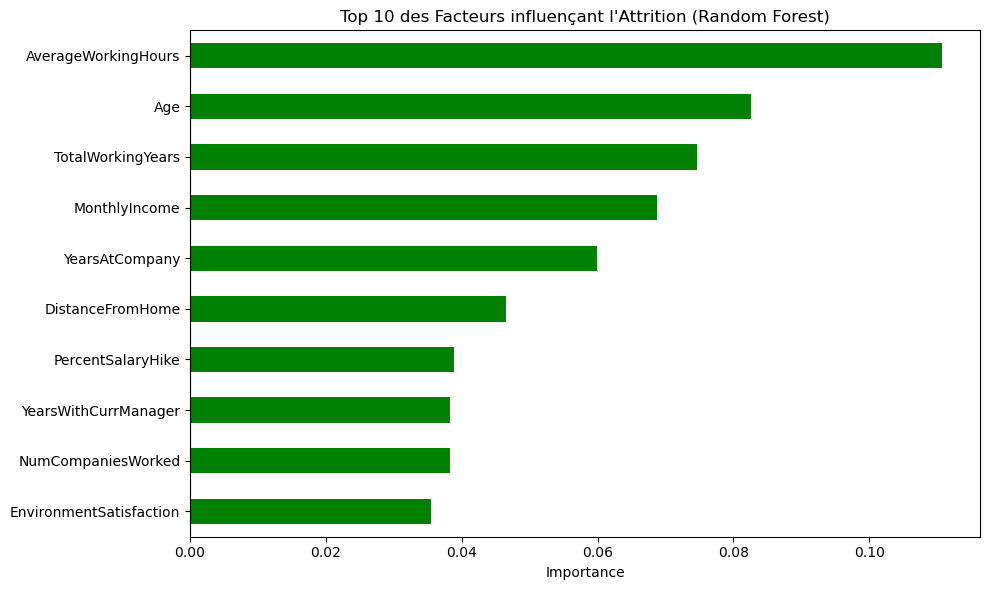

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

# --- 1. Chargement et Nettoyage Final pour le ML ---

# Si vous venez de charger le CSV
# df = pd.read_csv('csv_out/final_dataset.csv')
# Sinon, on utilise main_df de l'étape précédente
df = main_df.copy()

# Suppression des colonnes inutiles pour la prédiction
# EmployeeID : identifiant unique sans valeur prédictive
# EmployeeCount, Over18, StandardHours : Ces colonnes contiennent souvent une seule valeur unique (constantes) dans ce dataset spécifique
cols_to_drop = ['EmployeeID', 'EmployeeCount', 'Over18', 'StandardHours', 'Attrition', 'Attrition_Numeric'] 
# Note : On garde 'Attrition_Numeric' comme cible et on supprime 'Attrition' (texte)

# Vérifions si ces colonnes existent avant de les supprimer
existing_cols_to_drop = [col for col in cols_to_drop if col in df.columns]
X = df.drop(columns=[col for col in cols_to_drop if col in df.columns])
y = df['Attrition_Numeric'] # La cible (Target)

# --- 2. Encodage des Variables Catégorielles ---
# Les algo de ML ne comprennent que les chiffres. Il faut transformer "Sales", "Married", etc.
# On utilise pd.get_dummies pour le One-Hot Encoding (crée des colonnes Department_Sales, Department_HR...)
X_encoded = pd.get_dummies(X, drop_first=True)

print(f"Dimensions après encodage : {X_encoded.shape}")

# --- 3. Séparation Train / Test (Comme dans le WS) ---
# On garde 20% ou 30% des données pour tester le modèle à la fin
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.25, random_state=42, stratify=y)
# Note : 'stratify=y' est important ici car il y a peu de départs (15%), cela assure la même proportion dans le train et le test.

# --- 4. Mise à l'échelle (Scaling) ---
# Important pour la Régression Logistique (équivalent de la Régression Linéaire du WS)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==============================================================================
# MODÉLISATION (Adaptation du WS Regression -> Classification)
# ==============================================================================

# --- Modèle 1 : Régression Logistique ---
# C'est l'équivalent "Classification" de la Régression Linéaire. Simple et interprétable.
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test_scaled)

print("\n--- 1. Régression Logistique ---")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("\nClassification Report:\n", classification_report(y_test, y_pred_log))

# --- Modèle 2 : Random Forest (Forêt Aléatoire) ---
# Souvent plus performant que la régression simple pour les données RH complexes.
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train) # Les arbres n'ont pas forcément besoin de scaling
y_pred_rf = rf_model.predict(X_test)

print("\n--- 2. Random Forest ---")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

# ==============================================================================
# VISUALISATION DES RÉSULTATS (Évaluation)
# ==============================================================================

# 1. Matrice de Confusion (Remplace les nuages de points "Valeur réelle vs Prédite" du WS)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion - Reg Logistique')
plt.xlabel('Prédit')
plt.ylabel('Réel')

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Greens')
plt.title('Matrice de Confusion - Random Forest')
plt.xlabel('Prédit')
plt.ylabel('Réel')

plt.tight_layout()
plt.savefig('img/confusion_matrices.png')
plt.show()

# 2. Importance des Features (Spécifique au Random Forest)
# Cela répond à la demande du client : "Quels sont les facteurs qui influencent le turnover ?"
importances = pd.Series(rf_model.feature_importances_, index=X_encoded.columns)
top_10_features = importances.nlargest(10)

plt.figure(figsize=(10, 6))
top_10_features.sort_values().plot(kind='barh', color='green')
plt.title('Top 10 des Facteurs influençant l\'Attrition (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.savefig('img/feature_importance.png')
plt.show()

Taille avant SMOTE: Attrition_Numeric
0    2774
1     533
Name: count, dtype: int64
Taille après SMOTE: Attrition_Numeric
0    2774
1    2774
Name: count, dtype: int64

--- 1b. Régression Logistique (Après SMOTE) ---
Accuracy: 0.7552130553037172

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.76      0.84       925
           1       0.37      0.75      0.50       178

    accuracy                           0.76      1103
   macro avg       0.66      0.75      0.67      1103
weighted avg       0.85      0.76      0.78      1103

Fitting 3 folds for each of 18 candidates, totalling 54 fits

--- Meilleurs paramètres Random Forest ---
{'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 50}

--- 2b. Random Forest (Optimisé) ---
Accuracy: 0.9873073436083409

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       925
           1       1.00      0.92  

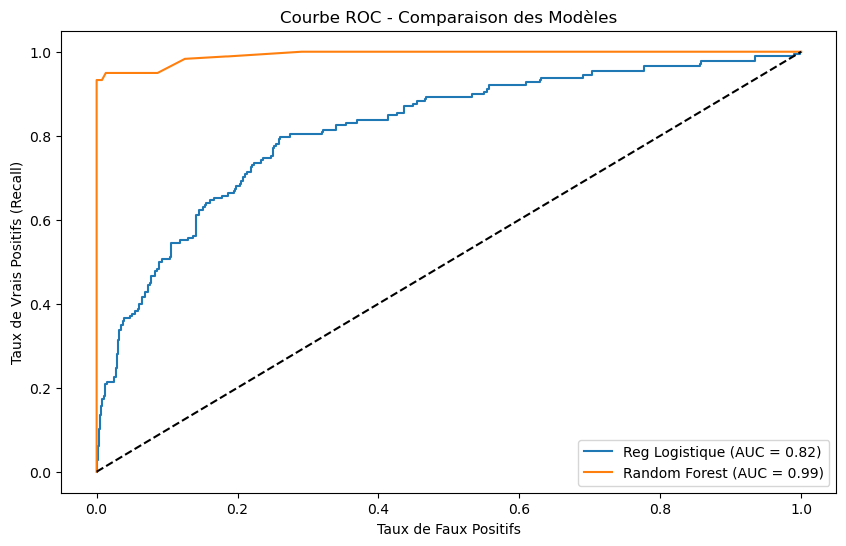

In [18]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

# ==============================================================================
# AMÉLIORATION 1 : Rééquilibrage des classes (SMOTE) pour la Régression Logistique
# ==============================================================================
# SMOTE crée des employés "synthétiques" qui partent pour forcer le modèle à mieux apprendre cette classe.

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(f"Taille avant SMOTE: {y_train.value_counts()}")
print(f"Taille après SMOTE: {y_train_smote.value_counts()}")

# Ré-entraînement sur données équilibrées
log_reg_smote = LogisticRegression(max_iter=1000)
log_reg_smote.fit(X_train_smote, y_train_smote)
y_pred_log_smote = log_reg_smote.predict(X_test_scaled)

print("\n--- 1b. Régression Logistique (Après SMOTE) ---")
print("Accuracy:", accuracy_score(y_test, y_pred_log_smote))
print("\nClassification Report:\n", classification_report(y_test, y_pred_log_smote))
# Observez si le Recall (classe 1) augmente (probablement au détriment de la précision).

# ==============================================================================
# AMÉLIORATION 2 : Optimisation des Hyperparamètres (GridSearch) pour Random Forest
# ==============================================================================
# On cherche la meilleure configuration pour éviter le sur-apprentissage (Overfitting).

param_grid = {
    'n_estimators': [50, 100],        # Nombre d'arbres
    'max_depth': [10, 20, None],      # Profondeur max des arbres
    'min_samples_leaf': [1, 2, 4]     # Nombre min d'échantillons par feuille
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=3, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("\n--- Meilleurs paramètres Random Forest ---")
print(grid_search.best_params_)

best_rf = grid_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)

print("\n--- 2b. Random Forest (Optimisé) ---")
print("Accuracy:", accuracy_score(y_test, y_pred_best_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best_rf))

# ==============================================================================
# VISUALISATION FINALE : Courbe ROC
# ==============================================================================
# La courbe ROC permet de comparer visuellement la performance globale des modèles.

y_prob_log = log_reg.predict_proba(X_test_scaled)[:, 1]
y_prob_rf = best_rf.predict_proba(X_test)[:, 1]

fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(10, 6))
plt.plot(fpr_log, tpr_log, label=f'Reg Logistique (AUC = {roc_auc_score(y_test, y_prob_log):.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_prob_rf):.2f})')
plt.plot([0, 1], [0, 1], 'k--') # Ligne du hasard (modèle inutile)
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs (Recall)')
plt.title('Courbe ROC - Comparaison des Modèles')
plt.legend()
plt.savefig('img/roc_curve.png')
plt.show()